In [3]:
%matplotlib inline

import sys
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from skimage import exposure, img_as_float, morphology

from osgeo import gdal
import osr
import xml.etree.ElementTree as ET
import os, fnmatch



In [ ]:
# open geotiff
#MS_filePath = "C:/Users/samrari/ComputBuffer/Image/Sen2/IMG_DATA/"
#MS_fileName = "S2A_OPER_MSI_L1C_TL_MPS__20161101T001337_A007105_T58KFA_B02.jp2"
#in_image = gdal.Open( MS_filePath + MS_fileName )

#driver = gdal.GetDriverByName("GTiff")
#src_ds = driver.CreateCopy((MS_filePath + MS_fileName[:-3] + "TIF"), in_image, 1)
#src_ds = None
#in_image = None



# Library of functions

In [4]:
def Get_RGBNIR(src_ds):

    NIR = src_ds.GetRasterBand(4).ReadAsArray()
    RGB_img = np.dstack((src_ds.GetRasterBand(1).ReadAsArray(),\
                         src_ds.GetRasterBand(2).ReadAsArray(),\
                         src_ds.GetRasterBand(3).ReadAsArray()))
    better_contrast = np.empty(RGB_img.shape, dtype= RGB_img.dtype)
    return NIR, RGB_img, better_contrast
    
def GetFiles(pattern, directory=os.curdir, TimLim=1964): 
    '''find all files with difined filename pattern in defined directory.'''
    
    files = os.listdir(os.path.abspath(directory))
    for current_file in fnmatch.filter(files, pattern):
        if int(current_file[1:5])>=TimLim:
            yield current_file
        
def isInsid(E, N, E_range, N_range):
    if (E_range[0] < E < E_range[1]):
        if (N_range[0] < N < N_range[1]):
            return True
        else:
            return False
    else:
        return False

def isInsid2(E, N, E_range, N_range):
    n = len(E)
    return np.logical_and(np.logical_and(np.tile(E_range[0],(n)) < E, E < np.tile(E_range[1], (n)))\
            ,np.logical_and(np.tile(N_range[0],(n)) < N, N < np.tile(N_range[1], (n))))

def GetXml_byLocation(RePath_xmlDirectory, E, N):
    Selected_xml = []
    count = 0
    LoopCount = 0

    for xmlFile in GetFiles("*.xml",directory=RePath_xmlDirectory):
        count = count+1
        root = ET.parse(RePath_xmlDirectory+'/'+xmlFile).getroot()
        E_range = (float(root.find('Attribute[@name="lonmin"]').find('Value').text), \
                   float(root.find('Attribute[@name="lonmax"]').find('Value').text) )
        N_range = (float(root.find('Attribute[@name="latmin"]').find('Value').text), \
                   float(root.find('Attribute[@name="latmax"]').find('Value').text))

        if isInsid(E, N, E_range, N_range):
            Selected_xml.append(xmlFile)
            LoopCount = LoopCount +1
    return Selected_xml, LoopCount, count

def GetXml_byFootprint(RePath_xmlDirectory, E_range, N_range, FromYear=1950):
    Selected_xml = []
    count = 0
    LoopCount = [0,0,0,0]

    for xmlFile in GetFiles("*.xml",directory=RePath_xmlDirectory, TimLim=FromYear):
        count = count+1
        root = ET.parse(RePath_xmlDirectory+'/'+xmlFile).getroot()
        lonmin = float(root.find('Attribute[@name="lonmin"]').find('Value').text)
        latmin = float(root.find('Attribute[@name="latmin"]').find('Value').text)
        lonmax = float(root.find('Attribute[@name="lonmax"]').find('Value').text)
        latmax = float(root.find('Attribute[@name="latmax"]').find('Value').text)
        setIn = False

        if isInsid(lonmin, latmin, E_range, N_range):
            setIn = True      
            LoopCount[0] = LoopCount[0] +1
        elif isInsid(lonmax, latmax,E_range, N_range):
            setIn = True  
            LoopCount[1] = LoopCount[1] +1
        elif isInsid(lonmin, latmax,E_range, N_range):
            setIn = True  
            LoopCount[2] = LoopCount[2] +1
        elif isInsid(lonmax, latmin, E_range, N_range):
            setIn = True  
            LoopCount[3] = LoopCount[3] +1

        if setIn:
            Selected_xml.append(xmlFile)

    return Selected_xml, LoopCount, count

def GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N, FromYear=1950):
    Selected_xml = []
    count = 0
    LoopCount = [0,0,0,0]

    for xmlFile in GetFiles("*.xml",directory=RePath_xmlDirectory,TimLim=FromYear):
        count = count+1
        root = ET.parse(RePath_xmlDirectory+'/'+xmlFile).getroot()

        setIn = False

        if isInsid(float(root.find('Attribute[@name="lonmin"]').find('Value').text),\
                   float(root.find('Attribute[@name="latmin"]').find('Value').text),\
                   (min_E, max_E), (min_N, max_N)):
            setIn = True      
            LoopCount[0] = LoopCount[0] +1
        elif isInsid(float(root.find('Attribute[@name="lonmax"]').find('Value').text),\
                   float(root.find('Attribute[@name="latmax"]').find('Value').text),\
                   (min_E, max_E), (min_N, max_N)):
            setIn = True  
            LoopCount[1] = LoopCount[1] +1
        elif isInsid(float(root.find('Attribute[@name="lonmin"]').find('Value').text),\
                   float(root.find('Attribute[@name="latmax"]').find('Value').text),\
                   (min_E, max_E), (min_N, max_N)):
            setIn = True  
            LoopCount[2] = LoopCount[2] +1
        elif isInsid(float(root.find('Attribute[@name="lonmax"]').find('Value').text),\
                   float(root.find('Attribute[@name="latmin"]').find('Value').text),\
                   (min_E, max_E), (min_N, max_N)):
            setIn = True  
            LoopCount[3] = LoopCount[3] +1

        if setIn:
            Selected_xml.append(xmlFile)
            
    return Selected_xml, LoopCount, count

def GetSurvey_byDepthFP(XML_List, RePath_xmlDirectory, E_range, N_range, max_Depth=40):
    # initilise
    Set_Point = []
    Set_Depth = []
    Set_xml = []
    countValidPT = []
    NoValid_xml = []
    for i, xml in enumerate(XML_List):
        # read current xml
        try:
            DepthPt = pd.read_csv(RePath_xmlDirectory+'/'+xml[:-10]+'ascii', delim_whitespace=True, header=None, names=['Lat','Lon','Depth'])
            # filter by depth
            DepthPt_40m = DepthPt[DepthPt['Depth']<=max_Depth]
            DepthPt_40m = DepthPt_40m[0<DepthPt_40m['Depth']]
            # loads points
            current_pt =  DepthPt_40m[['Lon','Lat']].values
            current_depth =  DepthPt_40m['Depth'].values
            # looks for points inside footprint
            index = isInsid2(current_pt[:,0], current_pt[:,1], E_range, N_range)
            # records points
            Set_Point.extend(current_pt[index,:])
            Set_Depth.extend(current_depth[index])
            root = ET.parse(RePath_xmlDirectory+'/'+xml).getroot()
            Set_xml.extend(np.tile((xml,root.find('Attribute[@name="SURSTA"]').find('Value').text),(np.sum(index), 1)))
            countValidPT.append(np.sum(index))     
        except:
            # in case of invalid xml path
            print('invalid at row: ', i)
            NoValid_xml.append(xml)
    return [np.asarray(Set_xml),  np.asarray(Set_Point), np.asarray(Set_Depth)], countValidPT, NoValid_xml

def GetSurvey_byDepthFP2(XML_List, RePath_xmlDirectory, E_range, N_range, max_Depth=40):
    # initilise
    Set_Selected = []
    Set_Point = []
    countValidPT = []
    NoValid_xml = []
    for i, xml in enumerate(XML_List):
        # read current xml
        try:
            DepthPt = pd.read_csv(RePath_xmlDirectory+'/'+xml[:-10]+'ascii', delim_whitespace=True, header=None, names=['Lat','Lon','Depth'])
            # filter by depth
            DepthPt_40m = DepthPt[DepthPt['Depth']<=max_Depth]
            # update book of points
            current_pt =  np.asarray(DepthPt_40m[['Lon','Lat','Depth']].values)
            index = isInsid2(current_pt[:,0], current_pt[:,1], E_range, N_range)
            Set_Selected.append(current_pt[index,:])
            Set_Point.extend([[ (pt[0], pt[1]), pt[2], i ] for  pt in current_pt[index,:]])
            countValidPT.append(np.sum(index))
        except:
            print(xml)
            NoValid_xml.append(NoValid_xml)
    return Set_Selected,  np.asarray(Set_Point), countValidPT, NoValid_xml

def recordSurvey(path_filname, Set): 
    with open(path_filname, 'w+') as mon_fichier:
        for i in range(len(Set[2])):
            print( Set[1][i,0], ';', Set[1][i,1], ';', Set[2][i], file= mon_fichier)

def GetPixel(ctInv, Inv_geomat, Coord):
    n = Coord.shape[0]
    x = np.zeros((n,))
    y = np.zeros((n,))
    for i in range(n):
        (X, Y, height) = ctInv.TransformPoint(Coord[i,0], Coord[i,1])
        x[i] = inv_geometrix[0] + inv_geometrix[1] * X + inv_geometrix[2] * Y
        y[i] = inv_geometrix[3] + inv_geometrix[4] * X + inv_geometrix[5] * Y
    return x, y 

def GetPixel2(ctInv, Inv_geomat, Coord):
    x = []
    y = []
    for i in range(Coord.shape[0]):
        (X, Y, height) = ctInv.TransformPoint(Coord[i,0], Coord[i,1])
        x.append(int(inv_geometrix[0] + inv_geometrix[1] * X + inv_geometrix[2] * Y))
        y.append(int(inv_geometrix[3] + inv_geometrix[4] * X + inv_geometrix[5] * Y))
    return x, y 

def GetPixel3(ctInv, Inv_geomat, Coord):

    XY = [ctInv.TransformPoint(Co[0], Co[1])[:2] for Co in Coord]
    x = [int(inv_geometrix[0] + inv_geometrix[1] * xy[0] + inv_geometrix[2] * xy[1]) for xy in XY]
    y = [int(inv_geometrix[3] + inv_geometrix[4] * xy[0] + inv_geometrix[5] * xy[1]) for xy in XY]

    return x, y 
        
#def GetPixel4(ctInv, Inv_geomat, Coord):
#
#
#    pix = [(int(inv_geometrix[0] + inv_geometrix[1] * xy[0] + inv_geometrix[2] * xy[1])\
#           int(inv_geometrix[3] + inv_geometrix[4] * xy[0] + inv_geometrix[5] * xy[1]))\
#           for xy in XY \
#           for XY in ctInv.TransformPoint(Co[0], Co[1])[:2]\
#           for Co in Coord]
#    return pix

# Metadatas extraction, reading and checking

In [6]:
xml_filePath = "C:/Users/samrari/ComputBuffer/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/"
xml_fileName = "MTD_MSIL1C.xml"
gdal.ErrorReset()
ds = gdal.Open( xml_filePath + xml_fileName )

if ds is None or gdal.GetLastErrorMsg() != '':
    print('xml failed to load')
    
DataSet_md = ds.GetMetadata()
SubDataSet_md = ds.GetMetadata('SUBDATASETS')
ds = []
DataSet_md


{'CLOUD_COVERAGE_ASSESSMENT': '0.7371',
 'DATATAKE_1_DATATAKE_SENSING_START': '2017-07-18T23:11:41.026Z',
 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS',
 'DATATAKE_1_ID': 'GS2A_20170718T231141_010823_N02.05',
 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING',
 'DATATAKE_1_SENSING_ORBIT_NUMBER': '101',
 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2A',
 'DEGRADED_ANC_DATA_PERCENTAGE': '0',
 'DEGRADED_MSI_DATA_PERCENTAGE': '0',
 'FOOTPRINT': 'POLYGON((166.35532632901763 -21.6970894719947, 166.46954229960608 -21.722967647825207, 166.46958826624325 -21.7227815159352, 166.47163316358743 -21.7232445791535, 166.4716453848504 -21.723194893765147, 166.47183341263485 -21.72323722848605, 166.4718497080836 -21.72317095690131, 166.71071733633568 -21.7773031127493, 166.71050830013448 -21.778173871448455, 166.9264041597562 -21.83047594674156, 166.92645036494807 -21.830281694363315, 166.92658079158798 -21.830313185021467, 166.9266070084699 -21.830202736161407, 166.92874668649648 -21.830719126399448, 166.928830

In [7]:
# Try opening the 4 subdatasets
for i in range(4):
    gdal.ErrorReset()
    ds.append(gdal.Open(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)]))
    if ds is None or gdal.GetLastErrorMsg() != '':
        print('subdatasets failed to load')
        print(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)])
src_ds = ds[0]
ds[0].RasterCount

4

In [8]:
# check raster bands inventory
print("[ RASTER BAND COUNT ]: ", src_ds.RasterCount)
for band in range( src_ds.RasterCount ):
    band += 1
    print("[ GETTING BAND ]: ", band)
    srcband = src_ds.GetRasterBand(band)
    if srcband is None:
        continue

    stats = srcband.GetStatistics( True, True )
    if stats is None:
        continue

    print("[ STATS ] =  Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( \
                stats[0], stats[1], stats[2], stats[3] ),'\n')

MData = src_ds.GetMetadata()    
print('Metadata: ',(MData))

[ RASTER BAND COUNT ]:  4
[ GETTING BAND ]:  1
[ STATS ] =  Minimum=0.000, Maximum=7696.000, Mean=405.042, StdDev=517.371 

[ GETTING BAND ]:  2
[ STATS ] =  Minimum=0.000, Maximum=7011.000, Mean=620.378, StdDev=470.559 

[ GETTING BAND ]:  3
[ STATS ] =  Minimum=0.000, Maximum=7088.000, Mean=897.700, StdDev=462.508 

[ GETTING BAND ]:  4
[ STATS ] =  Minimum=0.000, Maximum=8257.000, Mean=812.492, StdDev=1089.928 

Metadata:  {'CLOUD_COVERAGE_ASSESSMENT': '0.7371', 'DATATAKE_1_DATATAKE_SENSING_START': '2017-07-18T23:11:41.026Z', 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS', 'DATATAKE_1_ID': 'GS2A_20170718T231141_010823_N02.05', 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING', 'DATATAKE_1_SENSING_ORBIT_NUMBER': '101', 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2A', 'DEGRADED_ANC_DATA_PERCENTAGE': '0', 'DEGRADED_MSI_DATA_PERCENTAGE': '0', 'FORMAT_CORRECTNESS_FLAG': 'PASSED', 'GENERAL_QUALITY_FLAG': 'PASSED', 'GENERATION_TIME': '2017-07-18T23:12:19.000000Z', 'GEOMETRIC_QUALITY_FLAG': 'PASSED', 

# Bands assignment and visualization

In [9]:
NIR = src_ds.GetRasterBand(4).ReadAsArray()
#R = src_ds.GetRasterBand(1).ReadAsArray()
#G = src_ds.GetRasterBand(2).ReadAsArray()#automaticly extract in numpy.ndarray of nuit16. Must be checked in case of other sat
#B = src_ds.GetRasterBand(3).ReadAsArray()
#RGB_img = np.dstack((R,G,B))
#del R, G, B

RGB_img = np.dstack((src_ds.GetRasterBand(1).ReadAsArray(),\
                     src_ds.GetRasterBand(2).ReadAsArray(),\
                     src_ds.GetRasterBand(3).ReadAsArray()))
better_contrast = np.empty(RGB_img.shape, dtype= RGB_img.dtype)


In [ ]:
%whos

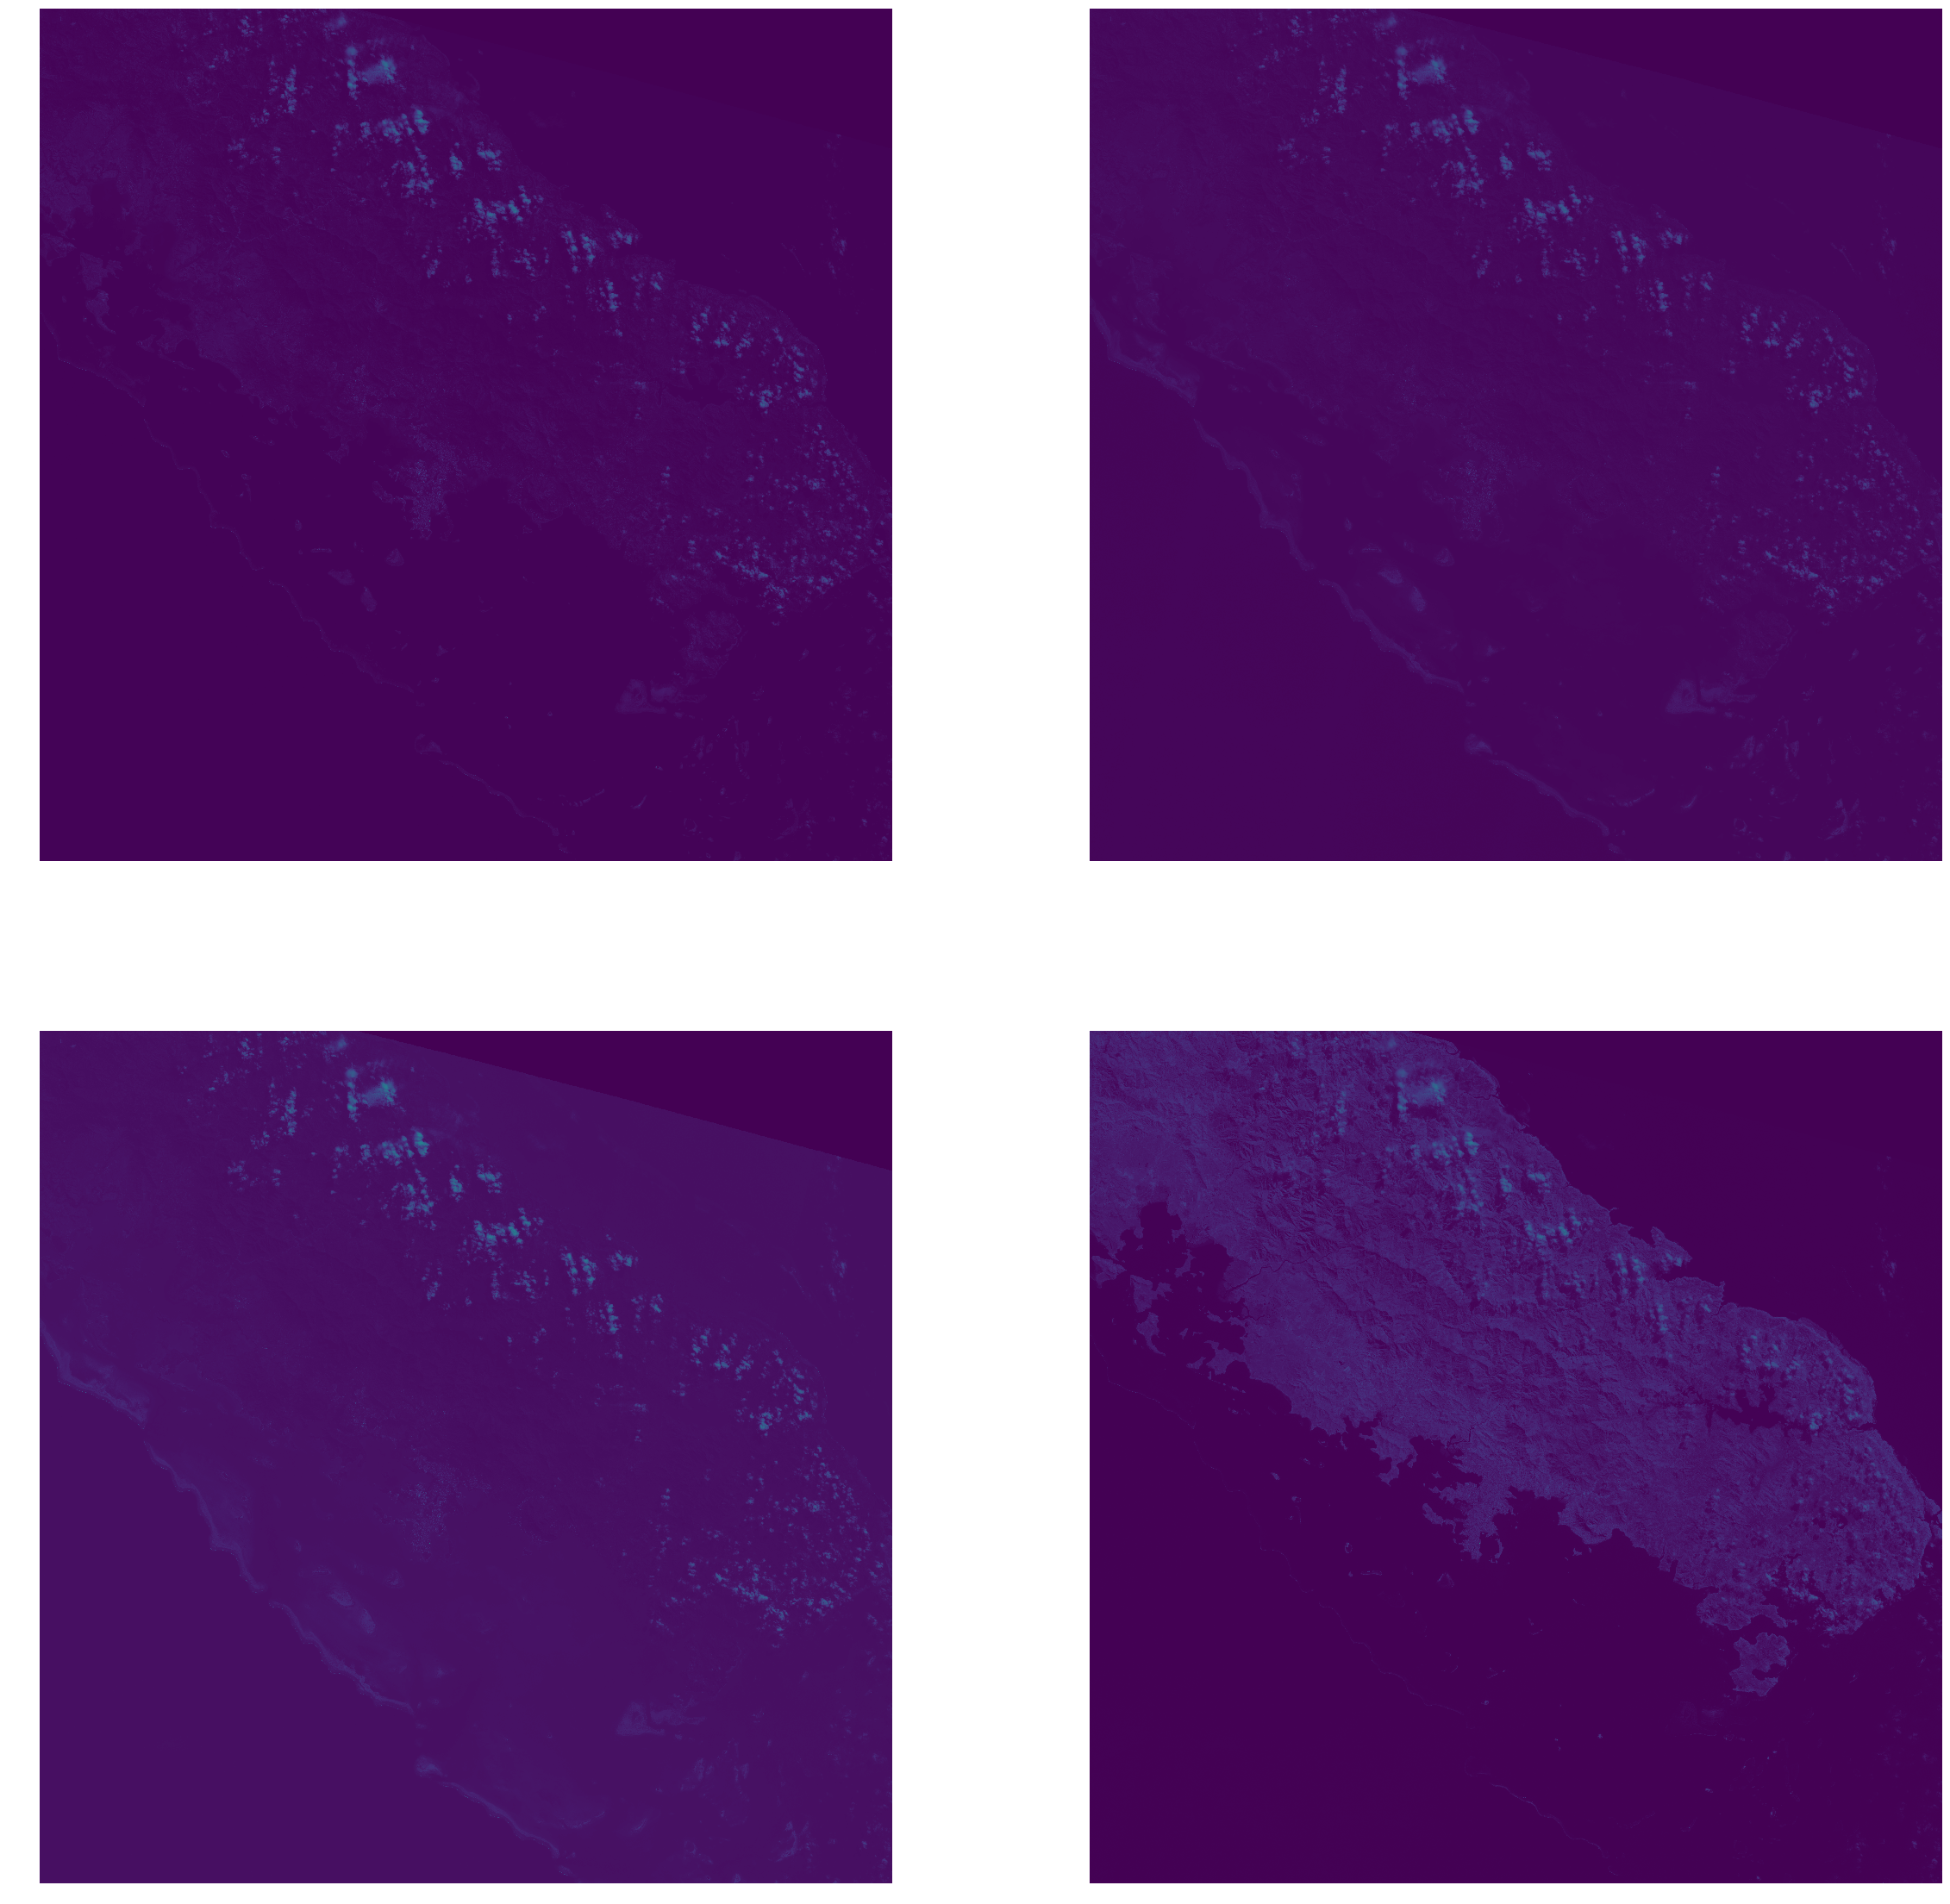

In [10]:
plt.figure(figsize=(40, 40))
for i in range(1,4):
    plt.subplot(2, 2, i)
    plt.imshow(img_as_float(RGB_img[:,:,i-1]))
    plt.axis('off')
#plt.subplot(1, 2, 2)
#plt.imshow(Random)

plt.subplot(2, 2, 4)
plt.imshow(img_as_float(NIR))
plt.axis('off')
plt.show
plt.savefig("figures/ChannelTestNC.png", dpi='figure')

# Display histograms bands

In [ ]:
plt.figure(figsize=(40, 40))
for i in range(1,4):
    plt.subplot(2, 2, i)
    plt.hist(RGB_img[:,:,i-1].ravel(), bins=400, ec='k')

plt.subplot(2, 2, 4)
plt.hist(NIR[:,:].ravel(), bins=400, ec='k')
plt.show

In [ ]:
%whos 

# Colors setting of visual

In [7]:
p_min = 5
p_max = 95
for i in range(RGB_img.shape[2]):
    v_min, v_max = np.percentile(RGB_img[:,:,i], (p_min, p_max))
    print('percentiles ',p_min,', ',p_max,' of band ',str(i),': ',str(v_min),', ',str(v_max),'\n')
    better_contrast[:,:,i] = exposure.rescale_intensity(RGB_img[:,:,i], in_range=(v_min, v_max))
    
print(better_contrast)
del RGB_img

percentiles  5 ,  95  of band  0 :  352.0 ,  2273.0 

percentiles  5 ,  95  of band  1 :  568.0 ,  2338.0 

percentiles  5 ,  95  of band  2 :  772.0 ,  2467.0 

[[[21765 19734 13300]
  [17535 18549 10671]
  [11189 15587  7926]
  ..., 
  [35820 39358 47517]
  [40460 37617 40016]
  [37355 32545 40480]]

 [[18967 18179 11135]
  [15658 17883  9588]
  [ 8460 11811  6882]
  ..., 
  [38379 38247 45043]
  [44178 35285 38006]
  [41586 42394 48252]]

 [[20366 19919 12295]
  [11599 16143  8428]
  [ 8938 12033  8583]
  ..., 
  [35786 34952 42027]
  [39334 32915 39939]
  [46669 42171 47827]]

 ..., 
 [[12963 11996 16122]
  [17705 12329 17321]
  [15658 10922 17746]
  ..., 
  [23812 23659 29577]
  [22925 22141 28688]
  [26098 23437 30737]]

 [[11769 13995 18133]
  [17910 11440 20646]
  [15147 12477 18635]
  ..., 
  [23232 22215 28881]
  [22925 25177 32786]
  [25995 27657 35647]]

 [[10985 11811 17707]
  [15931 10033 19254]
  [13202 13773 17669]
  ..., 
  [25108 22400 30041]
  [26916 25843 34720]
  [

In [ ]:
better_contrast.shape

In [ ]:
plt.figure(figsize=(20, 20))
#plt.subplot(1, 2, 1)
plt.imshow(img_as_float(better_contrast))
#plt.subplot(1, 2, 2)
#plt.imshow(Random)
plt.axis('off')
plt.show
plt.savefig("figures/CompoNC.jpg", dpi='figure')

In [ ]:
# Display histograms bands
plt.figure(figsize=(40, 40))
for i in range(1,4):
    plt.subplot(2, 2, i)
    plt.hist(better_contrast[:,:,i-1].ravel(), bins=400, ec='k')

plt.subplot(2, 2, 4)
plt.hist(NIR.ravel(), bins=400, ec='k')
plt.show

In [ ]:
plot_img = np.empty(RGB_img.shape, dtype=float)
for i in range(plot_img.shape[2]):
    plot_img[:,:,i] = exposure.equalize_hist(img_as_float(RGB_img[:,:,2-i]))
    
plt.figure(figsize=(20, 20))
#plt.subplot(1, 2, 1)
plt.imshow(plot_img)
#plt.subplot(1, 2, 2)
#plt.imshow(Random)
plt.axis('off')
plt.show


# NIR soil thresholding and mask cleaning

In [ ]:
# Test Threshold
NIR_thres = 1400
plot_img = img_as_float(better_contrast)
plot_img[NIR[:,:]>NIR_thres] = 0 
plt.figure(figsize=(20, 20))
#plt.subplot(1, 2, 1)
plt.imshow(plot_img)
#plt.subplot(1, 2, 2)
#plt.imshow(Random)
plt.axis('off')
plt.show

In [ ]:
# Cleaning : Comparison
plt.figure(figsize=(40, 40))
plt.subplot(1, 2, 1)
plt.imshow((NIR>NIR_thres))
plt.axis('off')

soilFilled_mask = morphology.remove_small_holes(NIR>NIR_thres,100000)
plt.subplot(1, 2, 2)
plt.imshow(soilFilled_mask)
plt.axis('off')
plt.show

In [ ]:
# Mask image
plot_img = img_as_float(better_contrast)
plot_img[soilFilled_mask] = np.NaN
plt.figure(figsize=(20, 20))
#plt.subplot(1, 2, 1)
plt.imshow(plot_img)
#plt.subplot(1, 2, 2)
#plt.imshow(Random)
plt.axis('off')
plt.show

# Look for common footprints

In [11]:
# Define Raster Footprint

RasterWidth = src_ds.RasterXSize
RasterHeight = src_ds.RasterYSize
GT_ds = src_ds.GetGeoTransform()
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3] 

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (165.9735606070099, -22.692427357900442) 
Lower right corner :  (167.02786117314153, -21.691015824552036)


In [ ]:
GT_ds[1]

# Look for common footprints : checks xml files

In [12]:
RePath_xmlDirectory = 'Data_SHOM/Global'
TimeThres = 1970
#%timeit GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N))
#%timeit GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N)
Selected_xml, LoopCount, count = GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)

In [ ]:
print('Number of xml files with common footprint: ',len(Selected_xml))
print('Number of xml within and without : ', count)
print('process check')
print(LoopCount)
print(np.sum(LoopCount))

# Look for common footprints : explore ascii

Lat         Lon  Depth
0    -22.347047  166.885908    8.7
1    -22.343378  166.882722    5.5
2    -22.347466  166.883780   27.9
3    -22.345047  166.883468   11.2
4    -22.346895  166.885193    9.7
5    -22.344397  166.881555   23.4
6    -22.345664  166.882571   32.5
7    -22.343835  166.882699    7.4
8    -22.342971  166.881063   16.1
9    -22.343397  166.881424   13.8
10   -22.341663  166.879839    2.9
11   -22.347955  166.885381   19.2
12   -22.348453  166.884749   36.5
13   -22.344508  166.883932    2.5
14   -22.345703  166.884356   14.0
15   -22.342339  166.881526    4.6
16   -22.347517  166.885564    9.5
17   -22.344724  166.880311   36.3
18   -22.346694  166.885012    9.9
19   -22.348149  166.884444   34.9
20   -22.343138  166.879385   19.0
21   -22.345983  166.885562    1.8
22   -22.344315  166.880717   20.4
23   -22.346457  166.883260   33.2
24   -22.346176  166.884142   19.2
25   -22.345046  166.883102   13.0
26   -22.345774  166.882743   32.5
27   -22.343891  166.880821   17.4
28   -22.344264  166.881659   21.4
29   -22.345352  166.882600   23.2
...         ...         ...    ...
5164 -22.342595  166.882674    2.6
5165 -22.344082  166.880900   20.0
5166 -22.342429  166.879435   15.7
5167 -22.345794  166.883629   21.6
5168 -22.346501  166.885952    3.9
5169 -22.343214  166.881787   12.2
5170 -22.342665  166.880705   15.5
5171 -22.343955  166.883081    5.2
5172 -22.344242  166.883708    2.8
5173 -22.346128  166.885937   -0.2
5174 -22.343741  166.880260   22.5
5175 -22.344494  166.882057   19.4
5176 -22.343919  166.880128   24.7
5177 -22.343587  166.881721   15.1
5178 -22.343190  166.879659   18.3
5179 -22.344048  166.882766    8.5
5180 -22.343912  166.883473    2.0
5181 -22.344372  166.881339   24.2
5182 -22.346022  166.885652    1.5
5183 -22.344011  166.883390    3.5
5184 -22.347056  166.885527   10.6
5185 -22.343905  166.883240    3.9
5186 -22.346719  166.884242   24.1
5187 -22.346543  166.885652    5.9
5188 -22.343141  166.879695   17.9
5189 -22.343240  166.879625   18.7
5190 -22.344164  166.883145    6.2
5191 -22.347766  166.884585   29.5
5192 -22.343735  166.882191    9.0
5193 -22.342912  166.882004   10.2

[5194 rows x 3 columns]

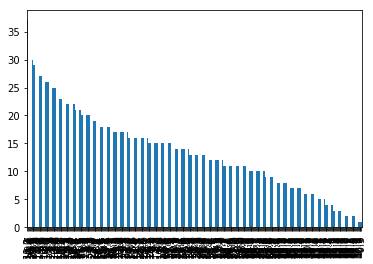

In [14]:
DepthPt = pd.read_csv(RePath_xmlDirectory+'/'+Selected_xml[0][:-10]+'ascii', delim_whitespace=True, header=None, names=['Lat','Lon','Depth'])
DepthPt_50m = DepthPt[DepthPt['Depth']<=50]
DepthPt_counts = DepthPt_50m['Depth'].value_counts()
DepthPt_counts.plot(kind='bar')
len(DepthPt_50m)
DepthPt_50m

# Look for common footprints : filters ascii by depth and footprint

In [ ]:

%timeit S_set, Set_point , C, failedXml = GetSurvey_byDepthFP2(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=30)
%timeit Set , Count, failedXml = GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=35)

In [15]:
Upto = 50
Set , Count, failedXml = GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]
Set[1].shape[0]

17995817

In [24]:
recordPosition('CSV/RelevesPos.csv', Set)

166.88106269999997

In [25]:
recordSurvey('Releves.csv', Set)


In [26]:
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)

px, py = GetPixel(ctInv, inv_geometrix, Set[1])

In [ ]:
%timeit GetPixel(ctInv, inv_geometrix, Set[1])
%timeit GetPixel2(ctInv, inv_geometrix, Set[1])
%timeit GetPixel3(ctInv, inv_geometrix, Set[1])

In [ ]:
%timeit GetPixel(ctInv, inv_geometrix, Set[1])


In [ ]:
px, py = GetPixel(ctInv, inv_geometrix, Set[1])
print(inv_geometrix)
print(RasterHeight)
print(RasterWidth)
print(GT_ds)

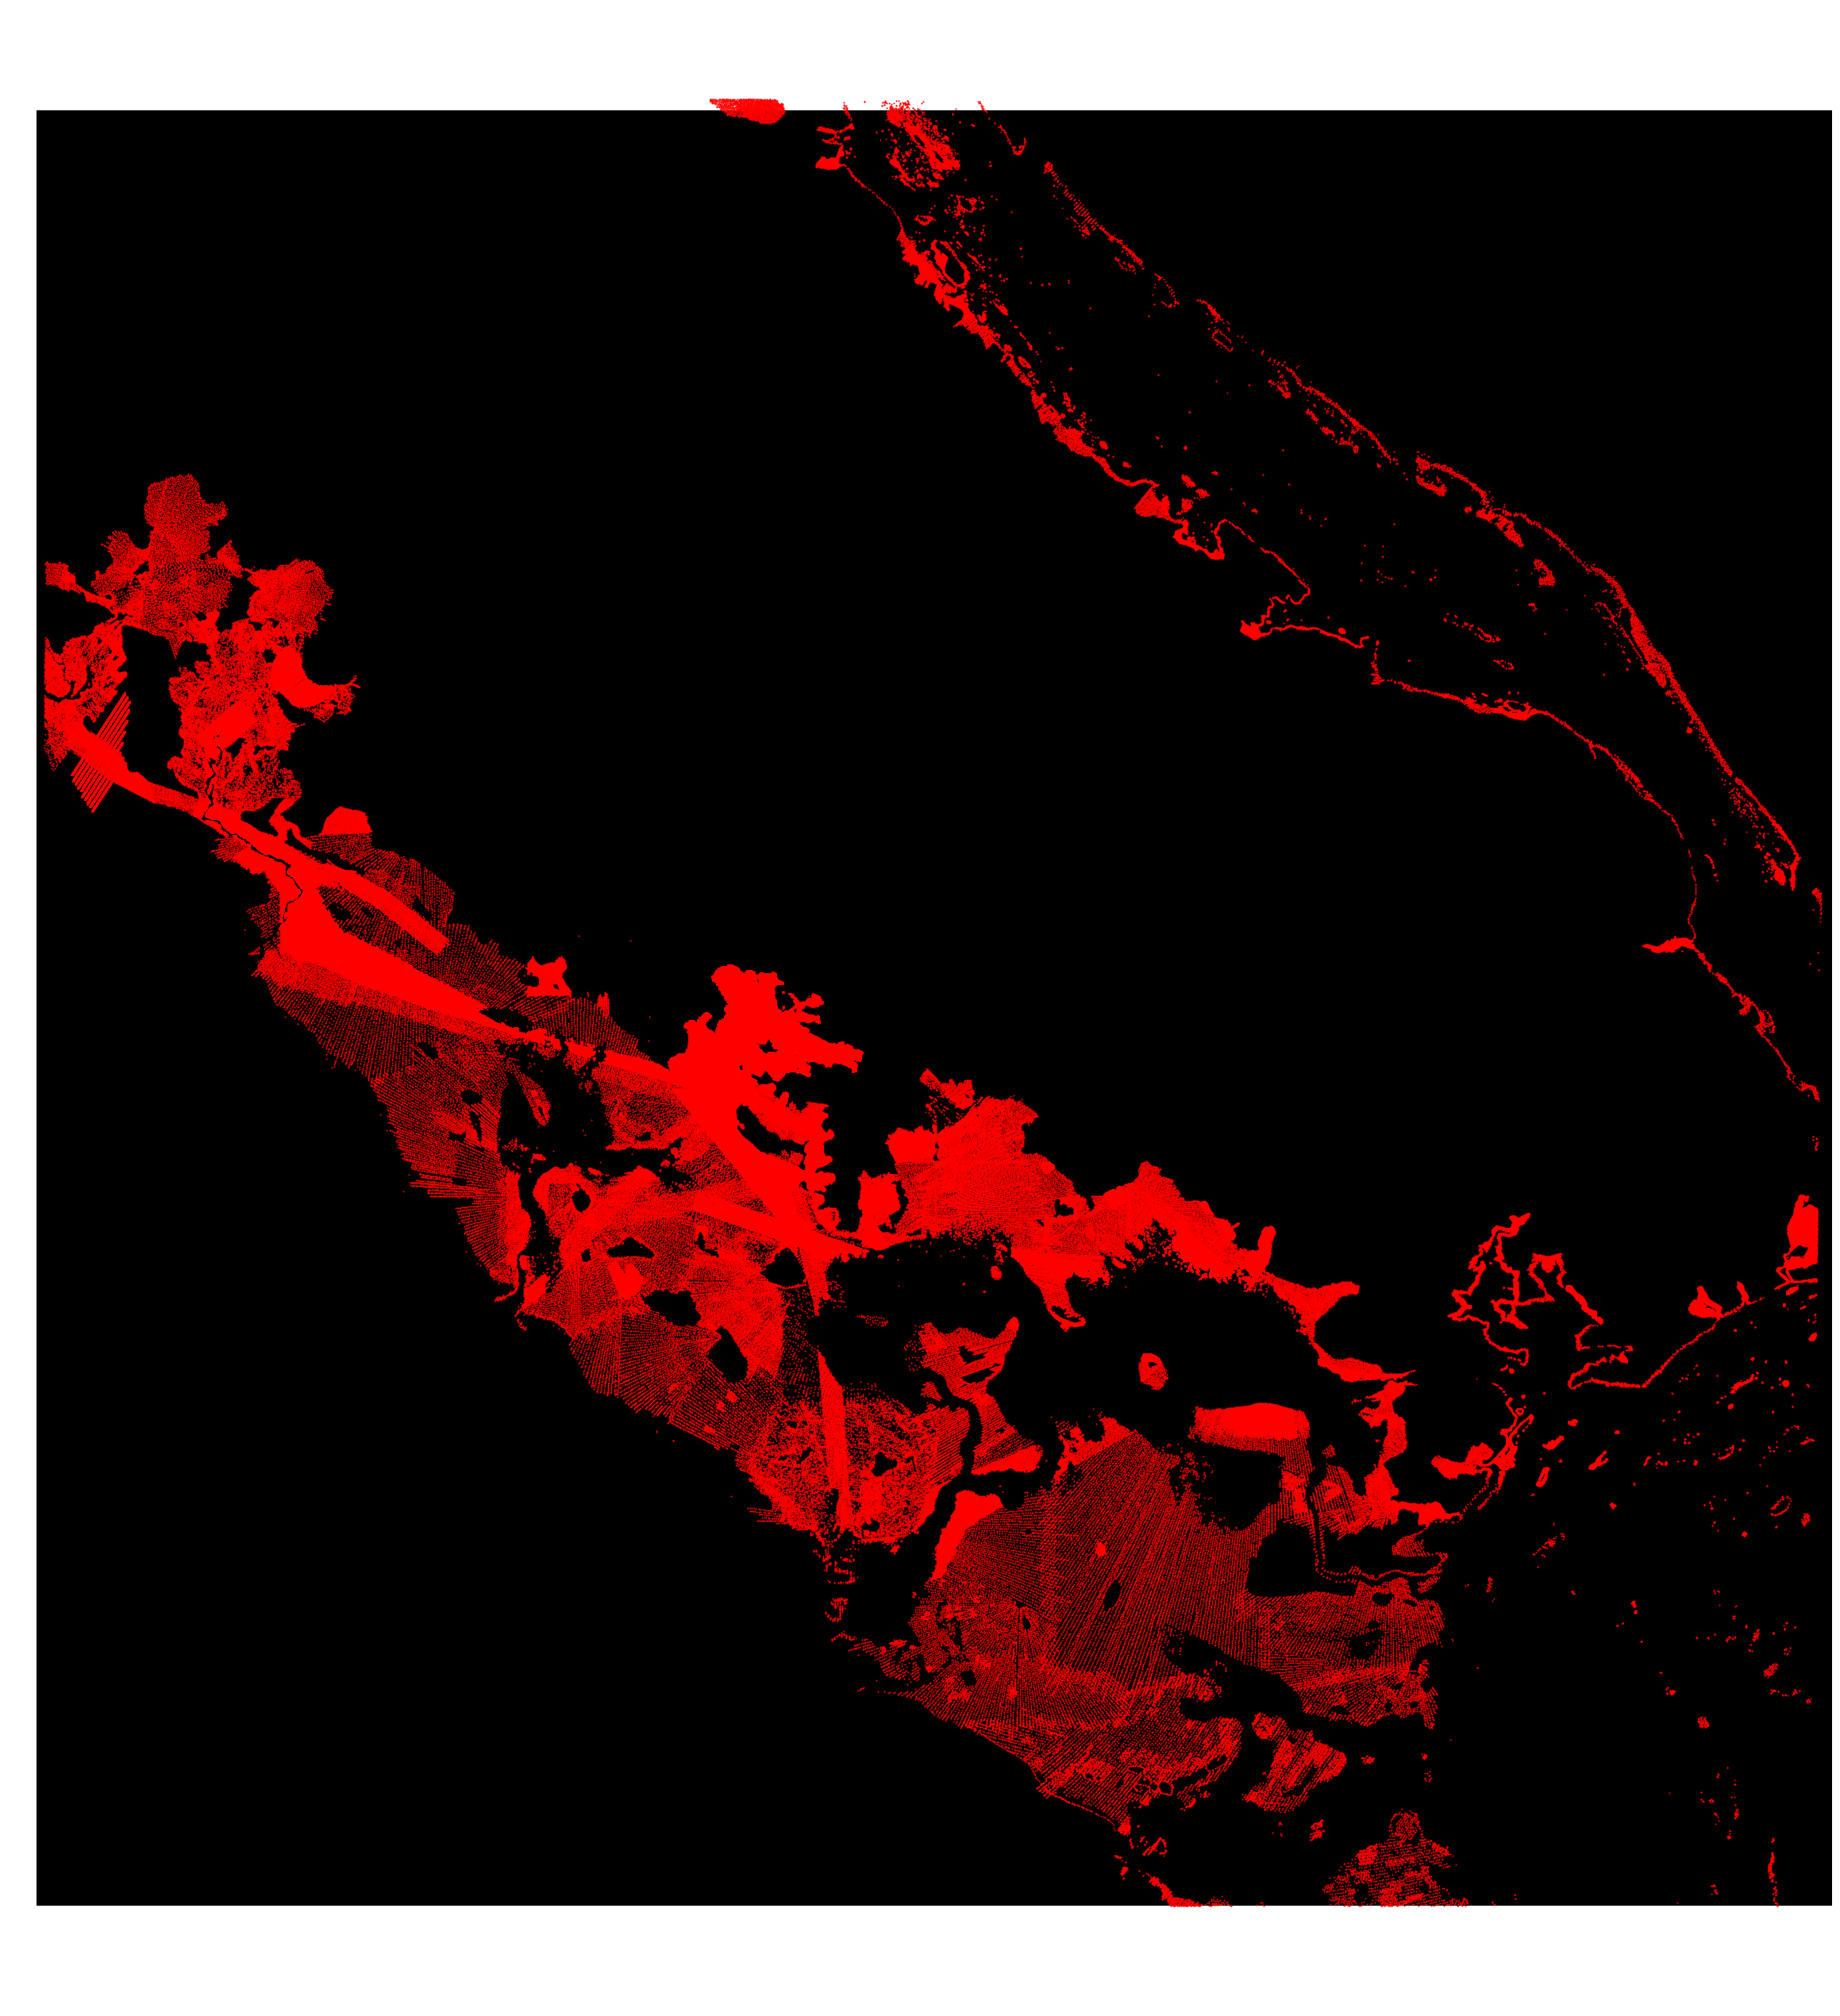

In [27]:
RePath_xmlDirectory = 'Data_SHOM/Global'
TimeThres = 1950
Upto = 25
Selected_xml, LoopCount, count = GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)
Set , Count, failedXml = GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]
px, py = GetPixel(ctInv, inv_geometrix, Set[1])
index= np.logical_not(np.logical_or(px>RasterWidth,py>RasterHeight,px<0))

Fig_Size = 40
fig = plt.figure(figsize=(Fig_Size, Fig_Size))
fig.subplots_adjust(left=0.01, bottom=0.01, wspace=0.95, hspace=0.95)
plt.imshow(img_as_float(better_contrast))
plt.scatter(px[index], py[index], c='r',s=1, zorder=2)
plt.axis('off')
plt.show
plt.savefig("figures/SurveyFrom"+str(TimeThres)+"Upto"+str(Upto)+"NC.png", dpi='figure', bbox_inches='tight', pad_inches=0.0)

In [ ]:
for i in range(1965,2016, 5):
    RePath_xmlDirectory = 'Data_SHOM/Global'
    TimeThres = i
    Upto = 25
    Selected_xml, LoopCount, count = GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)
    Set , Count, failedXml = GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
    assert np.sum(Count) == Set[1].shape[0]
    px, py = GetPixel(ctInv, inv_geometrix, Set[1])
    index= np.logical_not(np.logical_or(px>RasterWidth,py>RasterHeight,px<0))
    
    Fig_Size = 40
    fig = plt.figure(figsize=(Fig_Size, Fig_Size))
    fig.subplots_adjust(left=0.01, bottom=0.01, wspace=0.95, hspace=0.95)
    plt.imshow(img_as_float(better_contrast))
    plt.scatter(px[index], py[index], c='r',s=1, zorder=2)
    plt.axis('off')
    plt.show
    plt.savefig("figures/From"+str(TimeThres)+"/SurveyFrom"+str(TimeThres)+"Upto"+str(Upto)+"NC.png", dpi='figure', bbox_inches='tight', pad_inches=0.0)